In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import mahotas as mh
import json

In [3]:
import cactas as C

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'

In [5]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [6]:
with open(DATAPATH+'../ESUS_stroke_side.csv', 'r') as f:
    stroke_sides = f.read().replace('ESUS ','').split('\n')

STROKE_SIDES = {}
    
for l in stroke_sides[1:]:
    l_s = l.split(',')
    
    if len(l_s) != 5:
        continue
    
    id_ = l_s[0]
    age = l_s[1]
    sex = l_s[2]
    race = l_s[3]
    side = l_s[4]
    STROKE_SIDES[id_] = side

In [7]:
images, labels = C.Util.load(DATAPATH)

In [8]:
for key, val in image_data.items():
    stroke_side = STROKE_SIDES[key]
    print('file name', key)
    print('Stroke side', stroke_side)

file name 2
Stroke side R
file name 5
Stroke side R
file name 6
Stroke side L
file name 7
Stroke side L
file name 9
Stroke side R
file name 10
Stroke side L
file name 12
Stroke side L
file name 13
Stroke side L
file name 14
Stroke side L
file name 15
Stroke side L
file name 16
Stroke side L
file name 17
Stroke side R
file name 18
Stroke side L
file name 21
Stroke side R
file name 22
Stroke side L
file name 23
Stroke side L
file name 24
Stroke side R
file name 25
Stroke side L
file name 26
Stroke side R
file name 27
Stroke side R
file name 29
Stroke side R
file name 31
Stroke side L
file name 32
Stroke side R
file name 33
Stroke side R
file name 35
Stroke side L
file name 36
Stroke side R
file name 39
Stroke side L
file name 40
Stroke side R
file name 41
Stroke side R
file name 45
Stroke side L
file name 46
Stroke side R
file name 47
Stroke side L
file name 48
Stroke side L
file name 49
Stroke side R
file name 50
Stroke side R
file name 51
Stroke side L
file name 52
Stroke side R
file n

In [9]:
# normalize grayscale to 0..1
images, labels = C.Util.normalize(images, labels)

# for each scan
symp_i_patches = []
symp_l_patches = []
asymp_i_patches = []
asymp_l_patches = []

P=64

In [10]:
images.shape

(766, 512, 512, 1)

In [11]:
labels.shape

(766, 512, 512, 1)

In [12]:
# Crop

In [13]:
cropped_label = []
cropped_image = []

In [14]:
from skimage.filters import threshold_otsu

In [15]:
for i in range(labels.shape[0]):
    thresh = threshold_otsu(labels[i])
    binary = labels[i] > (0.5 * thresh)
    relabel, obj = mh.label(binary)
    
    #print(f"Number of objects in image {i}: {obj}")

    for j in range(1, relabel.max()+1):
        single_label = np.zeros((relabel.shape), relabel.dtype)
        single_label[relabel == j] = 1

        bbox = mh.bbox(single_label)
        #print(bbox)


        label_cropped = labels[i][bbox[0]:bbox[1],bbox[2]:bbox[3]] 
        image_cropped = images[i][bbox[0]:bbox[1],bbox[2]:bbox[3]]
        
        #print(label_cropped.shape)

        cropped_label.append(label_cropped)
        cropped_image.append(image_cropped)


In [17]:
len(cropped_label)

1417

In [18]:
len(cropped_image)

1417

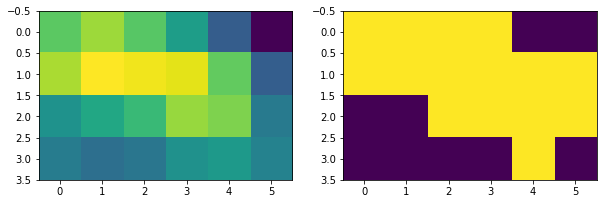

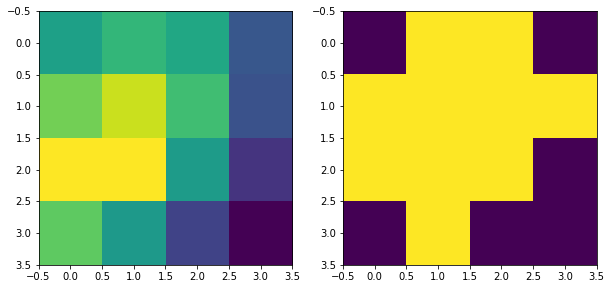

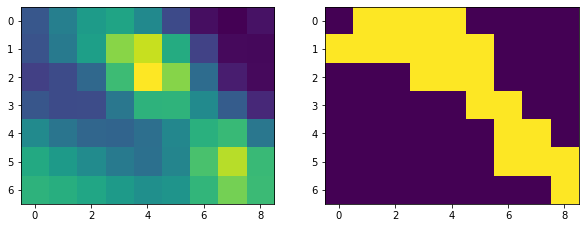

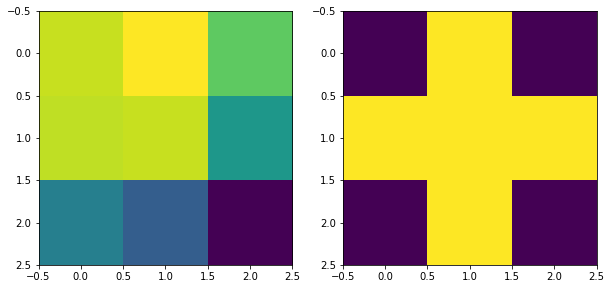

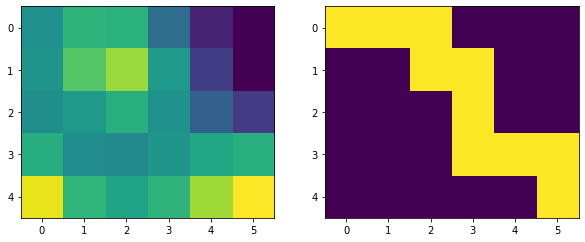

In [19]:
for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(cropped_image[i])
    ax2.imshow(cropped_label[i])
    plt.show()

In [20]:
# Pad

In [21]:
force_square=True
center=True

In [22]:
maxX = 0
maxY = 0
slicecount = len(cropped_label)

for i in cropped_image:
    maxY = max(maxY, i.shape[0])
    maxX = max(maxX, i.shape[1])

if force_square:
    maxY = max(maxY, maxX)
    maxX = max(maxY, maxX)

startY = 0
startX = 0

padded_images = np.zeros((slicecount, maxY, maxX, 1), dtype=cropped_image[0].dtype)
padded_labels = np.zeros((slicecount, maxY, maxX, 1), dtype=cropped_label[0].dtype)

currentslice = 0
for i, img in enumerate(cropped_image):
    if center:
        startY = (maxY - img.shape[0]) // 2
        startX = (maxX - img.shape[1]) // 2
  
    padded_images[currentslice, startY:startY+img.shape[0], startX:startX+img.shape[1]] = cropped_image[i] 
    padded_labels[currentslice, startY:startY+img.shape[0], startX:startX+img.shape[1]] = cropped_label[i]

    currentslice += 1

In [23]:
padded_images.shape

(1417, 30, 30, 1)

In [24]:
padded_labels.shape

(1417, 30, 30, 1)

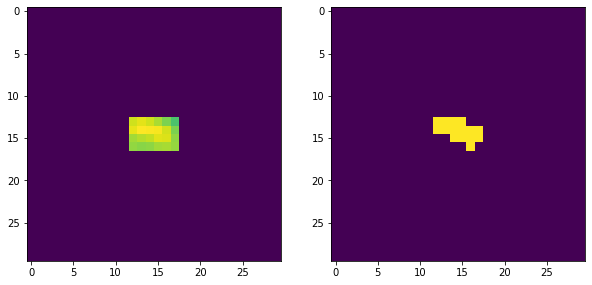

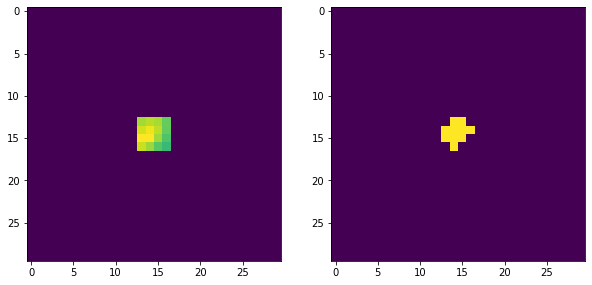

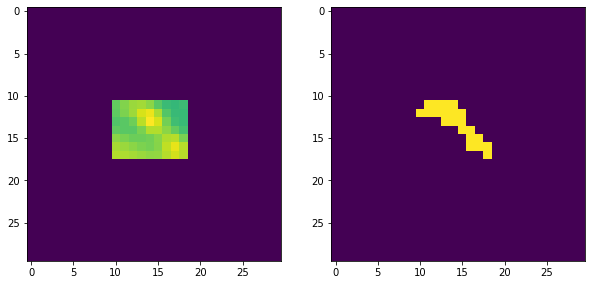

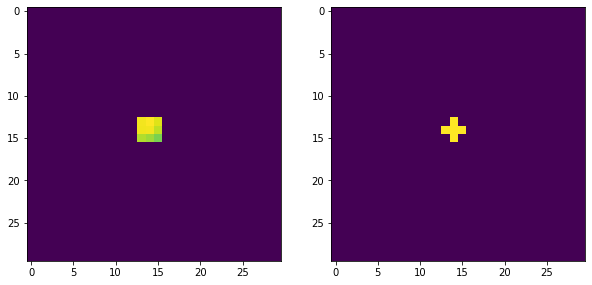

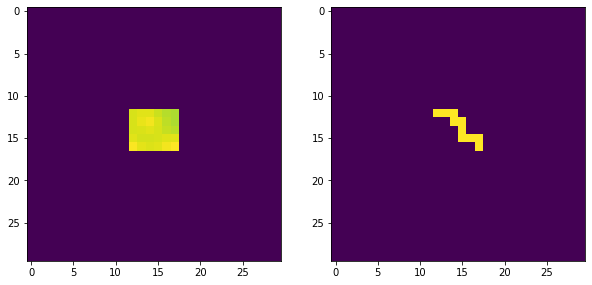

In [25]:
for i in range(5): # slicecount
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(padded_images[i])
    ax2.imshow(padded_labels[i])
    plt.show()